In [3]:
import h5py

filename = "/weka/oe-training-default/mm-olmo/robot_datasets/new_prompt_v3/vida_procthor_with_holodeck_assets/2025_07_15/tasks_HardObjectNavType_NoMemory_DoneEval_ObjectPointing_validation_shard0_cache.h5"

with h5py.File(filename, "r") as f:
    print("Top-level keys:", list(f.keys()))

    def print_tree(name, obj):
        kind = "Group" if isinstance(obj, h5py.Group) else "Dataset"
        print(f"{kind:8s}: {name}")

    f.visititems(print_tree)

Top-level keys: ['0', '1', '2', '3', '4']
Group   : 0
Dataset : 0/episode_id
Dataset : 0/frame_idx
Dataset : 0/house_id
Dataset : 0/image
Dataset : 0/prompt_scene_description
Dataset : 0/prompt_standard
Dataset : 0/target_action_scene_description
Dataset : 0/target_action_standard
Dataset : 0/task_type
Group   : 1
Dataset : 1/episode_id
Dataset : 1/frame_idx
Dataset : 1/house_id
Dataset : 1/image
Dataset : 1/prompt_scene_description
Dataset : 1/prompt_standard
Dataset : 1/target_action_scene_description
Dataset : 1/target_action_standard
Dataset : 1/task_type
Group   : 2
Dataset : 2/episode_id
Dataset : 2/frame_idx
Dataset : 2/house_id
Dataset : 2/image
Dataset : 2/prompt_scene_description
Dataset : 2/prompt_standard
Dataset : 2/target_action_scene_description
Dataset : 2/target_action_standard
Dataset : 2/task_type
Group   : 3
Dataset : 3/episode_id
Dataset : 3/frame_idx
Dataset : 3/house_id
Dataset : 3/image
Dataset : 3/prompt_scene_description
Dataset : 3/prompt_standard
Dataset : 3

In [5]:
import os

In [2]:
filename = "/weka/oe-training-default/mm-olmo/robot_datasets/new_prompt_v3/vida_procthor_with_holodeck_assets/2025_07_15/tasks_HardObjectNavType_NoMemory_DoneEval_ObjectPointing_validation_shard0_cache.h5"

In [10]:
np.sort(os.listdir('/weka/prior/datasets/vida_procthor_with_holodeck_assets/2025_07_15/tasks/HardObjectNavType/train'))

array(['000000', '000001', '000004', ..., '099993', '099994', '099995'],
      shape=(36499,), dtype='<U6')

In [9]:
import numpy as np

In [11]:
np.sort(os.listdir('/weka/prior/datasets/vida_procthor_with_holodeck_assets/2025_07_15/tasks/HardObjectNavType/val'))

array(['000000', '000001', '000004', ..., '009995', '009996', '009997'],
      shape=(5843,), dtype='<U6')

In [12]:
os.listdir('/weka/prior/datasets/vida_procthor_with_holodeck_assets/2025_07_15/tasks/HardObjectNavType/val/000000/')

['warped_left_camera__1.mp4',
 'hdf5_sensors.hdf5',
 'warped_right_camera__1.mp4',
 'warped_down_camera__0.mp4',
 'success.txt',
 'warped_front_camera__0.mp4',
 'warped_right_camera__0.mp4',
 'warped_down_camera__1.mp4',
 'warped_left_camera__0.mp4',
 'warped_front_camera__1.mp4']

In [32]:
import cv2
import numpy as np

def load_video_frames_cv2(mp4_path):
    """
    Load all frames from an MP4 file using OpenCV.
    
    Args:
        mp4_path: Path to the MP4 file
    
    Returns:
        numpy array of shape (num_frames, height, width, channels)
    """
    cap = cv2.VideoCapture(mp4_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {mp4_path}")
    
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # OpenCV reads in BGR, convert to RGB if needed
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    
    cap.release()
    
    # Convert list to numpy array
    frames_array = np.array(frames)
    
    return frames_array

# Example usage
mp4_path = "/weka/prior/datasets/vida_procthor_with_holodeck_assets/2025_07_15/tasks/HardObjectNavType/val/000001/warped_front_camera__0.mp4"
frames2 = load_video_frames_cv2(mp4_path)

print(f"Video shape: {frames.shape}")
print(f"Number of frames: {frames.shape[0]}")

Video shape: (33, 480, 640, 3)
Number of frames: 33


In [16]:
import matplotlib.pyplot as plt

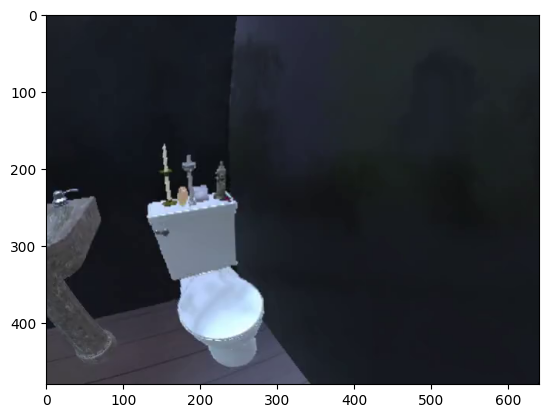

In [31]:
plt.imshow(frames[0])

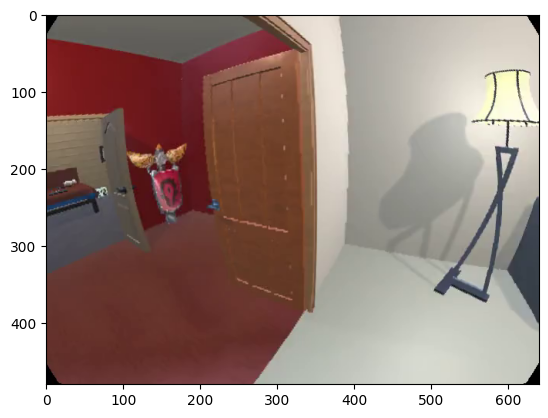

In [33]:
plt.imshow(frames2[0])

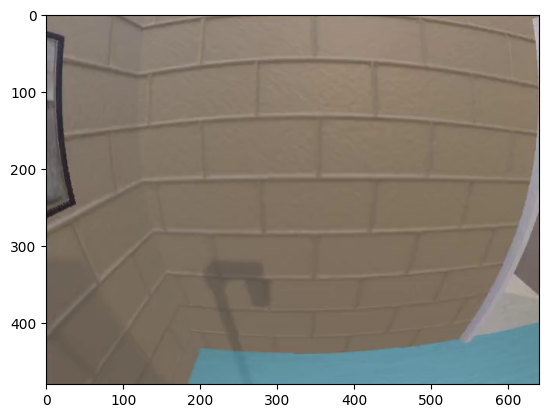

In [30]:
plt.imshow(frames2[0])

In [ ]:
import cv2
import numpy as np
import glob
import os
from pathlib import Path

def load_first_frame(mp4_path):
    """Load just the first frame from an MP4 file."""
    cap = cv2.VideoCapture(mp4_path)
    
    if not cap.isOpened():
        return None
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        return None
    
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame_rgb

def frames_match(frame1, frame2, threshold=0.99):
    """
    Check if two frames match.
    
    Args:
        frame1, frame2: numpy arrays
        threshold: similarity threshold (0-1), default 0.99 means 99% similar
    
    Returns:
        (bool, float): (match, similarity_score)
    """
    if frame1 is None or frame2 is None:
        return False, 0.0
    
    if frame1.shape != frame2.shape:
        return False, 0.0
    
    # Method 1: Exact pixel match
    exact_match = np.array_equal(frame1, frame2)
    if exact_match:
        return True, 1.0
    
    # Method 2: Mean Squared Error (lower is better)
    mse = np.mean((frame1.astype(float) - frame2.astype(float)) ** 2)
    
    # Method 3: Structural Similarity (0-1, higher is better)
    # Normalize to 0-1 range
    similarity = 1.0 / (1.0 + mse / 10000.0)  # Rough similarity score
    
    # Method 4: Correlation coefficient
    correlation = np.corrcoef(frame1.flatten(), frame2.flatten())[0, 1]
    
    return similarity > threshold or correlation > threshold, max(similarity, correlation)

# Load the validation episode 000001 first frame
val_episode = "000001"
val_base = "/weka/prior/datasets/vida_procthor_with_holodeck_assets/2025_07_15/tasks/HardObjectNavType/val"
val_video_path = f"{val_base}/{val_episode}/warped_front_camera__0.mp4"

print(f"Loading validation episode {val_episode}...")
val_first_frame = load_first_frame(val_video_path)

if val_first_frame is None:
    print(f"ERROR: Could not load {val_video_path}")
else:
    print(f"✓ Loaded val frame, shape: {val_first_frame.shape}")
    
    # Now search through all train episodes
    train_base = "/weka/prior/datasets/vida_procthor_with_holodeck_assets/2025_07_15/tasks/HardObjectNavType/train"
    
    # Find all episode directories in train
    train_episodes = sorted([d for d in os.listdir(train_base) 
                           if os.path.isdir(os.path.join(train_base, d)) and d.isdigit()])
    
    print(f"\nSearching through {len(train_episodes)} train episodes...")
    print("="*80)
    
    matches_found = []
    
    for i, train_episode in enumerate(train_episodes):
        if i % 100 == 0:
            print(f"Checked {i}/{len(train_episodes)} episodes...", end='\r')
        
        # Check front camera warped video (same as val)
        train_video_path = f"{train_base}/{train_episode}/warped_front_camera__0.mp4"
        
        if not os.path.exists(train_video_path):
            continue
        
        train_first_frame = load_first_frame(train_video_path)
        
        if train_first_frame is not None:
            is_match, similarity = frames_match(val_first_frame, train_first_frame, threshold=0.99)
            
            if is_match:
                matches_found.append({
                    'episode': train_episode,
                    'similarity': similarity,
                    'path': train_video_path
                })
                print(f"\n🚨 MATCH FOUND! Val episode {val_episode} matches train episode {train_episode}")
                print(f"   Similarity: {similarity:.4f}")
    
    print(f"\nChecked {len(train_episodes)} train episodes")
    print("="*80)
    
    if matches_found:
        print(f"\n⚠️  FOUND {len(matches_found)} MATCHING EPISODES!")
        for match in matches_found:
            print(f"  Val {val_episode} == Train {match['episode']} (similarity: {match['similarity']:.4f})")
    else:
        print(f"\n✓ No exact matches found. Episode {val_episode} appears unique to validation set.")
    
    # Additional check: Look for the same episode number in train
    if val_episode in train_episodes:
        print(f"\n⚠️  Episode {val_episode} EXISTS in train directory!")
        print(f"   Checking if it's the same video...")
        
        same_episode_path = f"{train_base}/{val_episode}/warped_front_camera__0.mp4"
        if os.path.exists(same_episode_path):
            train_same_frame = load_first_frame(same_episode_path)
            is_match, similarity = frames_match(val_first_frame, train_same_frame)
            
            if is_match:
                print(f"   🚨 YES! Train episode {val_episode} has IDENTICAL frames to val episode {val_episode}")
                print(f"   Similarity: {similarity:.4f}")
            else:
                print(f"   Episode {val_episode} exists in both but has different content (similarity: {similarity:.4f})")
    else:
        print(f"\n✓ Episode {val_episode} does not exist in train directory by number")

Loading validation episode 000001...
✓ Loaded val frame, shape: (480, 640, 3)

Searching through 36499 train episodes...
Checked 600/36499 episodes...